In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import test_utils
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    
    conv = layers.Conv2D(filters=n_filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(inputs)
    conv = layers.Conv2D(filters=n_filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(conv)
    
    if dropout_prob > 0:
        conv = layers.Dropout(dropout_prob)(conv)
        
    if max_pooling:
        next_layer = layers.MaxPooling2D(pool_size=(2, 2))(conv)
        
    else:
        next_layer = conv
        
    skip_connection = conv

    return next_layer, skip_connection

In [3]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    up = layers.Conv2DTranspose(filters=n_filters, kernel_size=3, strides=(2, 2), padding='same')(expansive_input)
    merge = layers.concatenate([up, contractive_input], axis=3)
    conv = layers.Conv2D(filters=n_filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(merge)
    conv = layers.Conv2D(filters=n_filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(conv)
    
    return conv

In [4]:
def unet_model(input_size=(256, 256, 3), n_filters=32, n_classes=23):
    inputs = layers.Input(input_size)
    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], n_filters * 2)
    cblock3 = conv_block(cblock2[0], n_filters * 4)
    cblock4 = conv_block(inputs=cblock3[0], n_filters=n_filters * 8, dropout_prob=0.3)
    cblock5 = conv_block(inputs=cblock4[0], n_filters=n_filters * 16, dropout_prob=0.3, max_pooling=False)
    
    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters * 8)
    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters * 4)
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters * 2)
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters)
    conv9 = layers.Conv2D(filters=n_filters, kernel_size=3, padding='same', kernel_initializer='he_normal')(ublock9)
    conv10 = layers.Conv2D(filters=n_filters, kernel_size=3, padding='same', kernel_initializer='he_normal')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)
    
    return model

In [5]:
img_height = 256
img_width = 256
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

In [6]:
unet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_3[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_8[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_9[0][0]  

 Total params: 8,648,960 (32.99 MB)

 Trainable params: 8,648,960 (32.99 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
image_path = "data/CameraRGB/"
mask_path = "data/CameraMask"

In [8]:
def get_image_paths(folder_path):
    image_paths = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(root, file))
    return image_paths

image_list = get_image_paths(image_path)
mask_list = get_image_paths(mask_path)

C:\Users\hecr\AppData\Local\Temp\ipykernel_6420\3911184542.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_list[199])
C:\Users\hecr\AppData\Local\Temp\ipykernel_6420\3911184542.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_list[199])


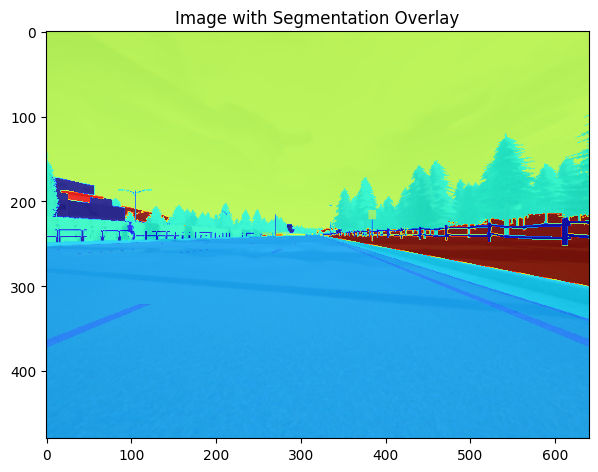

In [9]:
import imageio
img = imageio.imread(image_list[199])
mask = imageio.imread(mask_list[199])
mask = mask[:, :, 0]
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(img)
ax.imshow(mask, cmap='jet', alpha=0.8)
ax.set_title('Image with Segmentation Overlay')
plt.show()

In [10]:
image_filenames = tf.data.Dataset.list_files(image_list, shuffle=False)
masks_filenames = tf.data.Dataset.list_files(mask_list, shuffle=False)
dataset = tf.data.Dataset.zip((image_filenames, masks_filenames))

In [11]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3) #cnvert to tensor
    img = tf.image.convert_image_dtype(img, tf.float32) #normalize between [0, 1]

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True) #reduce the 3-channel mask to a single-channel mask
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (256, 256), method='nearest')
    input_mask = tf.image.resize(mask, (256, 256), method='nearest')

    return input_image, input_mask

image_mask_dataset = dataset.map(process_path)
processed_image_mask_dataset = image_mask_dataset.map(preprocess)


In [12]:
train_size = int(len(image_list) * 0.8)
valid_size = len(image_list) - train_size
print(f"train set size: {train_size}, validation set size {valid_size}")


train set size: 848, validation set size 212


In [13]:
def augment(image, mask):
    #apply random horizontal flip
    image = tf.image.random_flip_left_right(image)
    mask = tf.image.random_flip_left_right(mask)
    return image, mask

In [14]:
train_dataset = processed_image_mask_dataset.take(train_size)
val_dataset = processed_image_mask_dataset.skip(train_size)
batch_size = 8

# train_dataset = train_dataset.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=train_size).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

for image, mask in train_dataset.take(1):
    print(f"Image shape: {image.shape}")
    print(f"Mask shape: {mask.shape}")

Image shape: (8, 256, 256, 3)
Mask shape: (8, 256, 256, 1)


In [15]:
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=0.001,
#     decay_steps=1,
#     decay_rate=0.96,
#     staircase=True)

optimizer = tf.keras.optimizers.Adam(0.001)
unet.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
epochs = 5
history = unet.fit(train_dataset, validation_data=val_dataset, epochs=epochs)

Epoch 1/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.4879 - loss: 1.7169 - val_accuracy: 0.8335 - val_loss: 0.6853
Epoch 2/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.8597 - loss: 0.5218 - val_accuracy: 0.8479 - val_loss: 0.5541
Epoch 3/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.9010 - loss: 0.3430 - val_accuracy: 0.8700 - val_loss: 0.4344
Epoch 4/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.9163 - loss: 0.2834 - val_accuracy: 0.8783 - val_loss: 0.4419
Epoch 5/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.9272 - loss: 0.2518 - val_accuracy: 0.8719 - val_loss: 0.4621


C:\Users\hecr\AppData\Local\Temp\ipykernel_6420\974158325.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
C:\Users\hecr\AppData\Local\Temp\ipykernel_6420\974158325.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

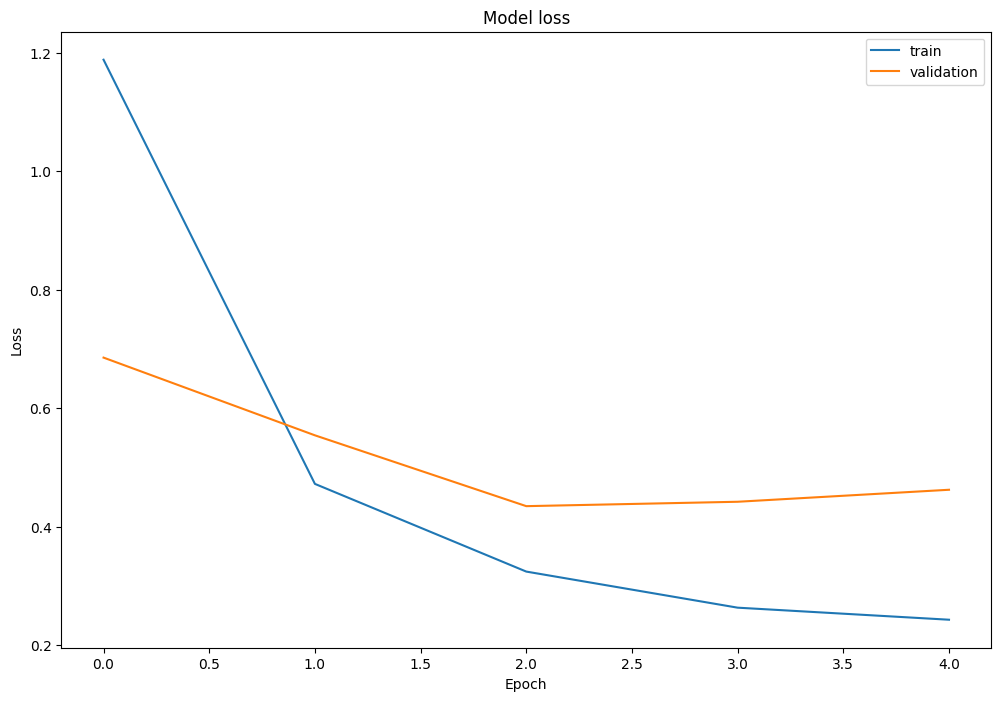

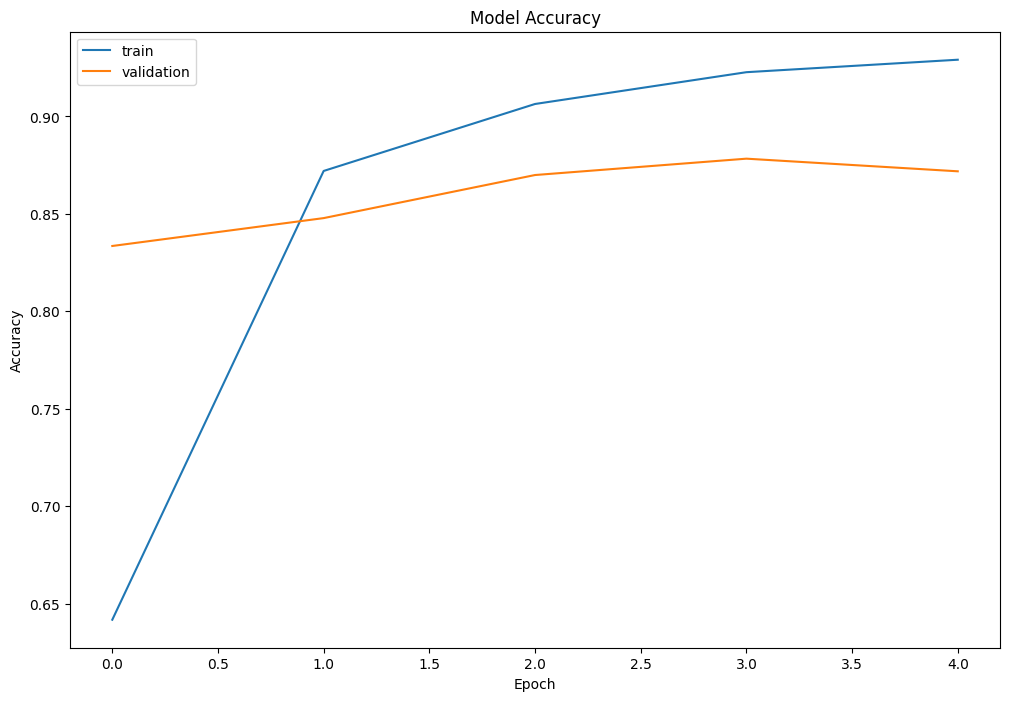

In [17]:
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')

In [18]:
unet.save('unet.keras')

In [43]:
def predict(image_path):
    def process_image(img):
        img = tf.io.read_file(img)
        img = tf.image.decode_png(img, channels=3) #cnvert to tensor
        img = tf.image.convert_image_dtype(img, tf.float32) #normalize between [0, 1]
        
        img = tf.image.resize(img, (256, 256), method='nearest')
        img = tf.expand_dims(img, axis=0)  
        
        return img
    image = process_image(image_path)
    prediction = unet.predict(image)
    predicted_mask = tf.argmax(prediction, axis=-1)  # If the output has multiple channels/

    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(tf.squeeze(image))  # Display the original image
    ax.imshow(tf.squeeze(predicted_mask), cmap='jet', alpha=0.7)  # Overlay the predicted mask
    ax.set_title('Image with Predicted Segmentation Overlay')
    plt.show()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


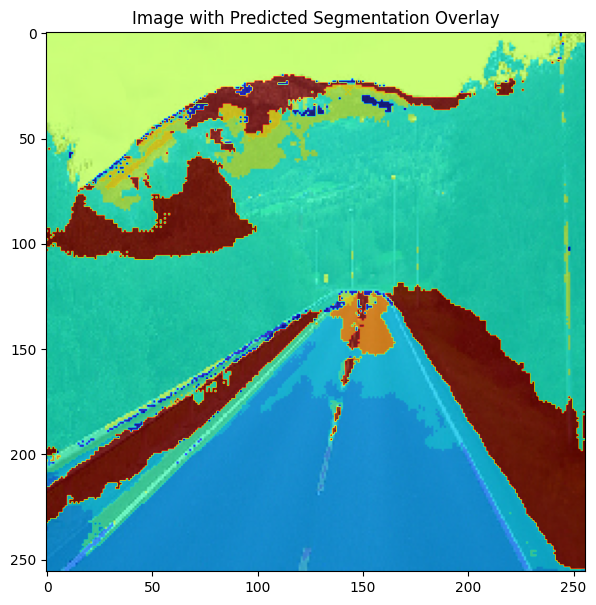

In [46]:
predict("tests/norway_road.jpg")

In [33]:
model = tf.keras.models.load_model("unet.keras")

In [34]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_3[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_8[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_9[0][0]  

 Total params: 25,946,882 (98.98 MB)

 Trainable params: 8,648,960 (32.99 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,297,922 (65.99 MB)